In [1]:
import numpy as np
import os
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
np.random.seed(0)

Premature Data Cleaning

In [2]:
# # read the dfs
# df = pd.read_feather("cluster_max_1000/clustered_df.df").set_index("key").sort_values(["City","Cluster","unique_cluster","frame_number"])
# seqs = pd.read_feather("max_distance_of_50.feather").set_index(["seq_key","new_unique_cluster"])

# # only keeps seqs with len 5
# seqs["len"] = seqs["keys"].apply(len)
# seqs = seqs.loc[seqs.len >= 5]
# df = df.loc[np.concatenate(seqs["keys"].values)]

# # set cluster id to images
# for (seq_key,cluster_id), val_df in tqdm.tqdm(seqs.iterrows()):

#     df.loc[val_df["keys"],"unique_cluster"] = cluster_id

# # rename clustesrs for clarity
# df.rename(columns={"Cluster":"City_Cluster","unique_cluster":"img_seq"},inplace=True)

# df.reset_index().to_feather("max_50_ready_for_split.feather")
# seqs.reset_index().to_feather("max_50_seqs_ready_for_split.feather")

Load the Data

In [3]:
df = pd.read_feather("max_50_ready_for_split.df").set_index("key")
seqs = pd.read_feather("max_50_seqs_ready_for_split.df").set_index(["seq_key","new_unique_cluster"])

Give seqs view counts

In [4]:
clusester_assingnments = df.groupby("sequence_key")["City_Cluster"].max()
seq_in = [i[0] for i in seqs.index.values]

seqs["City_Cluster"] = [clusester_assingnments.loc[f] for f in seq_in]

In [5]:
# trimmed_seqs = []

# # trim sequnces to multiple sub seuqnces of length 5
# for ((seq_key,cluster_id), ser) in seqs.iterrows():

#     keys = ser[3]
#     frames = ser[2]
#     slice = np.arange(5,len(keys)+1,2)

#     for i in slice:

#         trimmed_seqs.append( [keys[i-5:i],frames[i-5:i],seq_key,cluster_id,ser[6],ser[-1]])

# # create df
# trimmed_seqs = pd.DataFrame(trimmed_seqs,columns=["keys","frames","seq_key","cluster_id","view_direction","City_Cluster"])
# # add pahts
# trimmed_seqs["Paths"] = [df.loc[key,"Path"].values    for key in tqdm.tqdm(trimmed_seqs["keys"].values)]
# trimmed_seqs.Paths = trimmed_seqs.Paths + "/images/" + trimmed_seqs["keys"] + ".jpg"

# def get_city(paths):
#     path = paths[0]
#     return path[22:path.find("/",22)]

# # add city
# trimmed_seqs["City"] = trimmed_seqs["Paths"].apply(get_city)

# trimmed_seqs.to_feather("trimmed_seqs.feather")

In [6]:
trimmed_seqs = pd.read_feather("trimmed_seqs.feather")

Get View Counts

In [7]:
view_counts = {}

for seq_key, series in trimmed_seqs.groupby(["City","City_Cluster"])["view_direction"]:

    view_counts[seq_key] =  [(series == i).sum() for i in  ["Forward",'Sideways',"Backward"]]

view_counts = pd.DataFrame.from_dict(view_counts,orient="index",columns=["Forward",'Sideways',"Backward"]).set_index(pd.MultiIndex.from_tuples(view_counts.keys()))

For this task we only want to have the Sideways

In [8]:
n_sid = (trimmed_seqs.view_direction == "Sideways").sum()
n_sid * 0.1

2278.2000000000003

In [9]:
sorted = view_counts.sort_values("Sideways")
sorted = sorted[sorted["Sideways"]>0]

In [10]:
sid = sorted["Sideways"]
sid

ottawa     3         2
toronto    0         2
goa        6         3
saopaulo   5         4
austin     5         6
phoenix    15       16
austin     2        25
london     1        27
budapest   0        31
saopaulo   1        49
amsterdam  0        49
cph        0        66
paris      0        75
manila     0        89
melbourne  0       126
bangkok    0       185
sf         0       206
tokyo      0       271
berlin     0       279
london     0       319
austin     0       587
phoenix    0       719
trondheim  0      1178
moscow     0      1818
helsinki   0      2202
ottawa     0     14448
Name: Sideways, dtype: int64

In [11]:
vals = ["trondheim","london","phoenix","cph"]
sid.loc[vals,[0,0,0,0]].sum()

2282

In [12]:
test = ["moscow","berlin","manila","saopaulo","amsterdam"]
sid.loc[test,[0,0,0,1,0]].sum()

2284

In [13]:
arrs = trimmed_seqs.iloc[:,[-3,-1]].values

def get_val_mask(i):

    return i[1] in vals and i[0]==0

val_mask = np.array([get_val_mask(i) for i in arrs])

def get_test_mask(i):

    ci,clu = arrs[i]

    if clu in ["moscow","berlin","manila","amsterdam"] and ci ==0:
        return True

    if clu == "saopaulo" and ci == 1:
        return True
    
    return False

def flip_50_percent(df):

    flip = df.loc[df.view_direction == "Sideways"].sample(frac=0.5,random_state=0).index

    df.loc[flip,"keys"] = df.loc[flip,"keys"].apply(lambda x: x[::-1])
    df.loc[flip,"Paths"] = df.loc[flip,"Paths"].apply(lambda x: x[::-1])
    df.loc[flip,"Flip"] = True

    flip = df.loc[df.view_direction != "Sideways"].sample(frac=0.5,random_state=0).index
    df.loc[flip,"keys"] = df.loc[flip,"keys"].apply(lambda x: x[::-1])
    df.loc[flip,"Paths"] = df.loc[flip,"Paths"].apply(lambda x: x[::-1])
    df.loc[flip,"Flip"] = True

    df.loc[df.Flip.isna(),"Flip"] = False

    return df


test_mask = np.array([get_test_mask(i) for i in range(len(trimmed_seqs))])

val = trimmed_seqs.loc[val_mask]
test = trimmed_seqs.loc[test_mask]

front = test.loc[test["view_direction"]!="Sideways"].sample(n=2235,random_state = 0)
test_df = pd.concat([front,test.loc[test["view_direction"]=="Sideways"]]).sample(frac= 1,random_state = 0)

front = val.loc[val["view_direction"]!="Sideways"].sample(n=2235,random_state = 0)
val_df = pd.concat([front,val.loc[val["view_direction"]=="Sideways"]]).sample(frac= 1,random_state = 0)

train = trimmed_seqs.loc[~ (val_mask | test_mask)]
train.loc[train.view_direction != "Sideways"].reset_index().to_feather("sample_soundly_from_here.df")

In [14]:



front = train.loc[train["view_direction"]!="Sideways"].sample(n=18216,random_state = 0)
train_df = pd.concat([front,train.loc[train["view_direction"]=="Sideways"]]).sample(frac= 1,random_state = 0)

train_df,val_df,test_df = [flip_50_percent(i) for i in  [train_df,val_df,test_df]]

train_df["ds_type"] = "train"
val_df["ds_type"] = "val"
test_df["ds_type"] = "test"

df = pd.concat([train_df,val_df,test_df])

#df.reset_index().to_feather("../training/training.df")

In [15]:
#old = pd.read_feather("prelim.feather").set_index("key")
df["og_cluster"] = df["keys"].apply(lambda x: old.loc[x[0],"unique_cluster"])

print((df["og_cluster"] == df.cluster_id).mean())
#df.reset_index().to_feather("../training/training.df")

NameError: name 'old' is not defined

Lets have a look at the images sequences

In [17]:
df = pd.read_feather("../training/new_train_seqs.df")

In [23]:
df.columns

Index(['index', 'keys', 'frames', 'seq_key', 'cluster_id', 'view_direction',
       'City_Cluster', 'Paths', 'City', 'Flip', 'ds_type', 'og_cluster',
       'ind'],
      dtype='object')

100%|██████████| 5/5 [00:00<00:00, 17.06it/s]


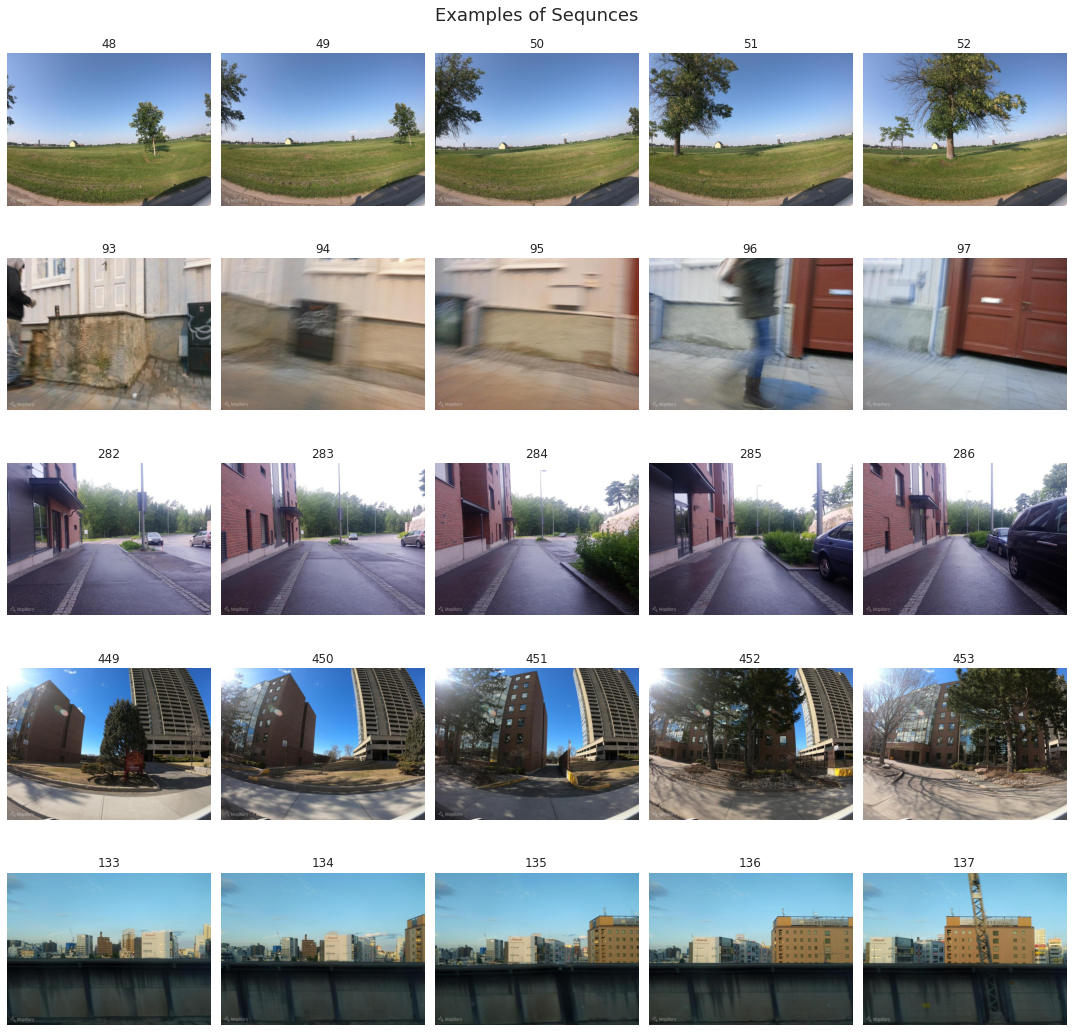

In [22]:
n = 5
p = df.sample(n=n)
fig,ax = plt.subplots(n,5,figsize=(15,3*n))

for i in tqdm.tqdm(range(n)):

    s = p.iloc[i]

    paths = s["Paths"]
    frames = s["frames"]

    for pos,(img,f) in enumerate(zip(paths,frames)):
        ax[i,pos].imshow(plt.imread("../../" + img))
        ax[i,pos].axis('off')
        ax[i,pos].set_title(f)

plt.suptitle("Examples of Sequnces",fontsize = 18)
plt.tight_layout()
plt.savefig("../../training_info/vd_imgs/examples_of_seqs.jpg")
plt.show()


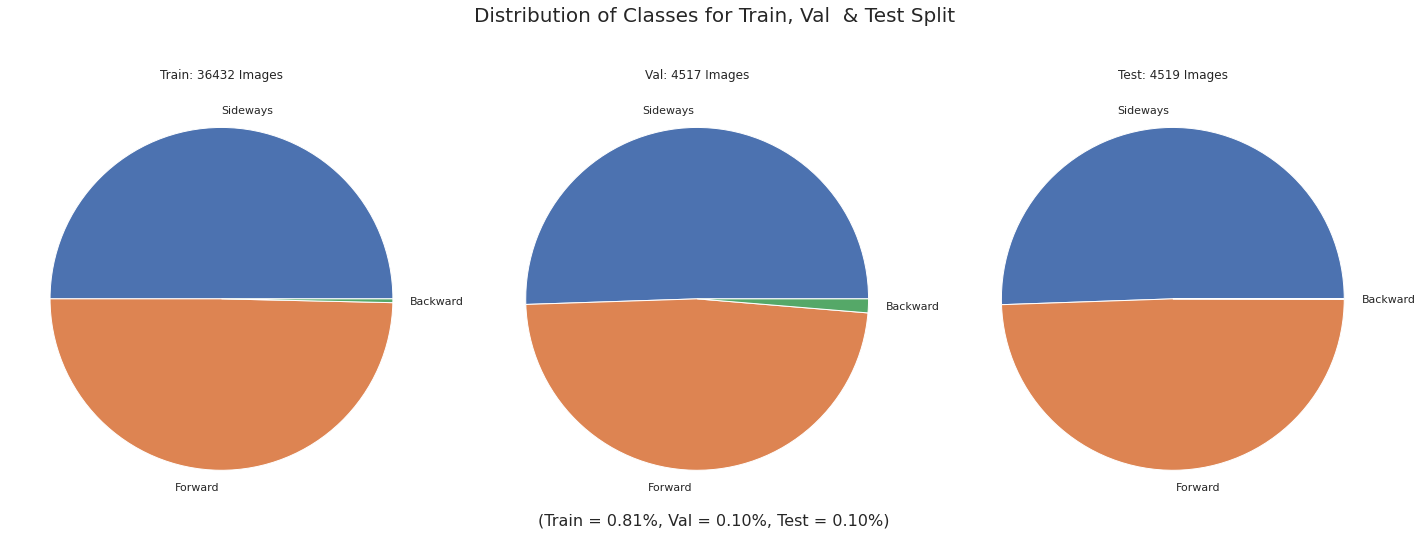

In [25]:
sns.set_theme()
def plot_pie(df,ax):

    x = df["view_direction"].value_counts()

    ax.pie(x.values,labels = x.index )

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Images')
ax[1].title.set_text(f'Val: {len(val_df)} Images')
ax[2].title.set_text(f'Test: {len(test_df)} Images')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1])
plot_pie(test_df,ax[2])
plt.suptitle(f"Distribution of Classes for Train, Val  & Test Split",fontsize=20)
plt.tight_layout()
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(df):.2f}%, Val = {len(val_df)/len(df):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
#plt.savefig("Imgs/Training Split.jpg")
plt.savefig("../../training_info/vd_imgs/split.jpg")
plt.show()

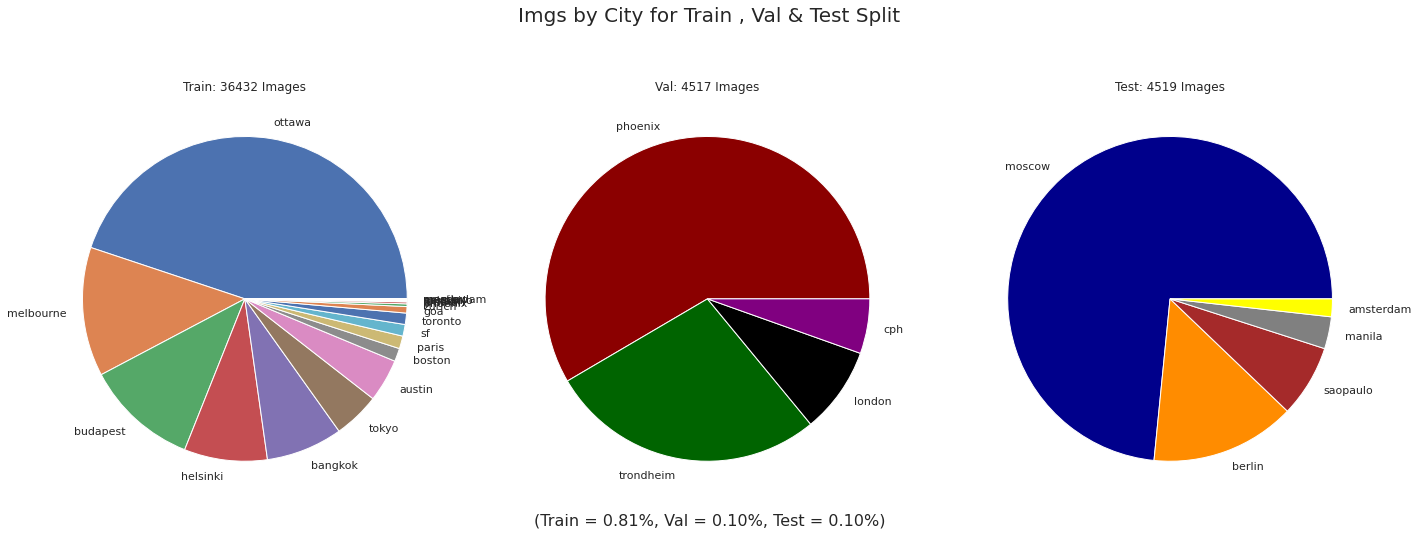

In [27]:
def plot_pie(df,ax,colors = None):

    x = df["City"].value_counts()

    ax.pie(x.values,labels = x.index ,colors = colors)

fig,ax = plt.subplots(1,3,figsize=[20,8])

ax[0].title.set_text(f'Train: {len(train_df)} Images')
ax[1].title.set_text(f'Val: {len(val_df)} Images')
ax[2].title.set_text(f'Test: {len(test_df)} Images')


plot_pie(train_df,ax[0])
plot_pie(val_df,ax[1],colors=["darkred","darkgreen","black","purple"])
plot_pie(test_df,ax[2],colors=["darkblue","darkorange","brown","grey","yellow"])
plt.suptitle(f"Imgs by City for Train , Val & Test Split", fontsize=20)
plt.figtext(0.5, 0.08, f"(Train = {len(train_df)/len(df):.2f}%, Val = {len(val_df)/len(df):.2f}%, Test = {len(test_df)/len(df):.2f}%)", wrap=True, horizontalalignment='center', fontsize=16)
plt.tight_layout()
#plt.savefig("Imgs/Citys Split.jpg")
plt.savefig("../../training_info/vd_imgs/city_split.jpg")
plt.show()

Recheck the validity of the split

In [ ]:
from scipy.spatial.distance import cdist
imgs = pd.read_feather("max_50_ready_for_split.feather").set_index("key")

imgs = imgs.iloc[:,[0,1,-2]].sort_values("City")

df = df.sort_values("City")

for city in df["City"].unique():

    if df.loc[df["City"]==city,"ds_type"].nunique() > 1:
        
        seqs = df.loc[df["City"]==city]
        cords = imgs.loc[imgs["City"]==city]

        agg = []

        uni = seqs["ds_type"].unique()

        for i in uni:
            
            agg.append(np.concatenate(seqs.loc[seqs["ds_type"]==i,"keys"].values))

        one, two = [cords.loc[i].iloc[:,:-1].values for i in agg]

        deduct_min = np.min([one.min(axis=0),two.min(axis=0)],axis=0)
        one -= deduct_min
        two -= deduct_min

        min_distance = cdist(one,two).min()

        assert min_distance > 1000, "Unsafe Split"

        print(f"In city {city} the minimum distance of {uni[0]} and {uni[1]} images is {min_distance:.0f}m")



In city amsterdam the minimum distance of test and train images is 2629m
In city london the minimum distance of train and val images is 2216m
In city manila the minimum distance of test and train images is 2790m
In city moscow the minimum distance of test and train images is 5180m
In city phoenix the minimum distance of val and train images is 1613m
In city saopaulo the minimum distance of test and train images is 1892m
